# Kütüphaneler ve Tekrarlanabilirlik

Bu hücrede proje boyunca ihtiyacım olacak kütüphaneleri içe aktarıyorum.  
- os, glob, shutil, random: dosya işlemleri ve rastgelelik için,  
- math.ceil: sayı yuvarlama için,  
- numpy, seaborn, matplotlib: veri analizi ve görselleştirme için,  
- train_test_split: veriyi eğitim ve test setlerine ayırmak için,  
- tensorflow ve ImageDataGenerator: model eğitimi ve veri artırma için.  

Ayrıca her çalıştırmada aynı sonuçları almak için SEED = 42 ile hem tensorflow, hem numpy hem de random için seed ayarladım. Böylece model sonuçları tekrarlanabilir oluyor.


In [23]:
import os, glob, random, shutil
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tekrarlanabilirlik
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


# Veri Seti Klasörlerinin Bulunması

Bu hücrede Kaggle’daki LC25000 veri setinin klasör yolunu belirliyorum.  
Veri seti farklı Kaggle notebooklarında bazen farklı klasör isimleriyle gelebiliyor, o yüzden birkaç olası yol tanımlayıp hangisinin var olduğuna bakıyorum.

Ardından:
- find_class_dirs() fonksiyonunu yazıp içinde çok sayıda görsel bulunan (gerçek sınıf klasörleri olan) dizinleri buluyorum.
- Sadece **LUNG** sınıflarını seçiyorum (colon sınıflarını hariç tutuyorum).
- Son olarak seçilen lung klasörlerini ekrana yazdırıyorum.

Bu kısım sayesinde veri setini hangi klasörde olursa olsun doğru şekilde bulmuş ve sadece akciğer görüntülerini kullanacak şekilde filtrelemiş oluyorum.


In [24]:
# Kaggle input kökü: LC25000 farklı klasör isimleriyle gelebiliyor
BASE_IN = "/kaggle/input/lung-and-colon-cancer-histopathological-images"
candidates = [
    BASE_IN,
    os.path.join(BASE_IN, "lung_colon_image_set"),
    os.path.join(BASE_IN, "Lung and Colon Cancer Histopathological Images"),
]
root = next((p for p in candidates if os.path.exists(p)), BASE_IN)

def find_class_dirs(root_dir):
    """İçinde çok sayıda görsel olan yaprak klasörleri döndür."""
    class_dirs = []
    for cur, _, files in os.walk(root_dir):
        imgs = [f for f in files if f.lower().endswith(('.jpg','.jpeg','.png'))]
        if len(imgs) > 50:   # gerçek sınıf klasörleri
            class_dirs.append(cur)
    return sorted(class_dirs)

all_class_dirs = find_class_dirs(root)

# sadece LUNG sınıfları (colon’ları hariç tut)
lung_dirs = [p for p in all_class_dirs if "lung" in p.lower()]
assert len(lung_dirs) >= 3, f"Lung sınıfları bulunamadı. Bulunan: {lung_dirs}"

print("Seçilen lung sınıfları:")
for p in lung_dirs:
    print(" -", p)


Seçilen lung sınıfları:
 - /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca
 - /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n
 - /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca
 - /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n
 - /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc


# Veri Setinin Train / Valid / Test Olarak Ayrılması

Bu hücrede lung sınıflarını **train**, **valid** ve **test** olarak ayırıyorum.  
Önce SPLIT_ROOT altında train/valid/test klasörlerini oluşturuyorum. Sonra her sınıf için görselleri alıp belirlediğim oranlara göre ayırıyorum:  
- **test_ratio = 0.20** → verilerin %20’si test setine,  
- **valid_ratio = 0.10** → verilerin %10’u validation setine,  
- **train_ratio = 0.70** → kalan %70’i train setine gidiyor.

Ayrımı yaparken train_test_split kullanıyorum ve SEED sabit olduğu için her çalıştırmada aynı şekilde bölünmüş oluyor.  

Son olarak her sınıf için ayrı klasörler oluşturup dosyaları bu klasörlere sembolik link olarak (gerekirse kopyalayarak) yerleştiriyorum.  
Böylece model eğitiminde kullanabileceğim düzenli bir klasör yapısına sahip oluyorum.


In [25]:
# Hedef dizinler
SPLIT_ROOT = "/kaggle/working/lc25_lung_split"
TRAIN_DIR  = os.path.join(SPLIT_ROOT, "train")
VALID_DIR  = os.path.join(SPLIT_ROOT, "valid")
TEST_DIR   = os.path.join(SPLIT_ROOT, "test")

for d in [TRAIN_DIR, VALID_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)

# oranlar
test_ratio  = 0.20
valid_ratio = 0.10   # kalan %80'in içinden valid %10 (toplamda %8) değil, doğrudan %10 ayıracağız
train_ratio = 0.70

def safe_link(src, dst):
    if not os.path.exists(dst):
        try:
            os.symlink(src, dst)
        except:
            shutil.copy2(src, dst)

# Her sınıf için ayrı ayrı stratified ayrım
for cls_path in lung_dirs:
    cls_name = os.path.basename(cls_path).replace(" ", "_")
    imgs = sorted([os.path.join(cls_path, f) for f in os.listdir(cls_path)
                   if f.lower().endswith(('.jpg','.jpeg','.png'))])

    # Önce test’i ayır
    trainval, test = train_test_split(
        imgs, test_size=test_ratio, random_state=SEED, shuffle=True, stratify=None
    )
    # Kalanın içinden valid’i ayıracak şekilde oranla
    # train_ratio : valid_ratio = 0.70 : 0.10  (test zaten ayrıldı)
    rel_valid = valid_ratio / (train_ratio + valid_ratio)  # 0.10 / 0.80 = 0.125
    train, valid = train_test_split(
        trainval, test_size=rel_valid, random_state=SEED, shuffle=True, stratify=None
    )

    # klasörleri oluştur
    for base, arr in [(TRAIN_DIR, train), (VALID_DIR, valid), (TEST_DIR, test)]:
        dst_cls = os.path.join(base, cls_name)
        os.makedirs(dst_cls, exist_ok=True)
        for p in arr:
            safe_link(p, os.path.join(dst_cls, os.path.basename(p)))

print("Tamamlandı →", SPLIT_ROOT)


Tamamlandı → /kaggle/working/lc25_lung_split


# Her Split İçin Görsel Sayılarının Kontrolü

Bu hücrede train, valid ve test klasörlerindeki her sınıfta kaç tane görsel olduğunu sayıyorum.  
Bunu yapmak için:
- count_per_split() fonksiyonunu yazdım; verilen kök dizinde (train/valid/test) dolaşıp her sınıfta kaç dosya olduğunu buluyor.
- Sonuçları bir sözlük (dictionary) olarak döndürüyor.

Bu kontrolü yaparak verilerin gerçekten doğru oranlarda (train %70, valid %10, test %20) ayrılıp ayrılmadığını görebiliyorum.  
Böylece veri bölme adımının doğru çalıştığından emin oluyorum.


In [26]:
def count_per_split(root_dir):
    counts = {}
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(root_dir, split)
        split_counts = {c: len(glob.glob(os.path.join(split_dir, c, "*")))
                        for c in sorted(os.listdir(split_dir))}
        counts[split] = split_counts
    return counts

counts = count_per_split(SPLIT_ROOT)
counts


{'train': {'colon_aca': 3499,
  'colon_n': 3499,
  'lung_aca': 3499,
  'lung_n': 3499,
  'lung_scc': 3499},
 'valid': {'colon_aca': 501,
  'colon_n': 501,
  'lung_aca': 501,
  'lung_n': 501,
  'lung_scc': 501},
 'test': {'colon_aca': 1000,
  'colon_n': 1000,
  'lung_aca': 1000,
  'lung_n': 1000,
  'lung_scc': 1000}}

# Veri Dağılımının ve Örnek Görsellerin Görselleştirilmesi

Burada önce **train/valid/test** setlerindeki sınıf dağılımlarını barplot ile görselleştiriyorum.  
Böylece her sınıfta yaklaşık aynı sayıda örnek olup olmadığını ve oranların doğru şekilde ayarlandığını hızlıca görebiliyorum.  

Ardından her sınıftan rastgele bir görsel seçip yan yana gösteriyorum.  
Bu sayede verilerin gerçekten doğru şekilde ayrıldığını, dosya yollarının düzgün çalıştığını ve görsellerin beklediğim gibi olduğunu gözümle kontrol edebiliyorum.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


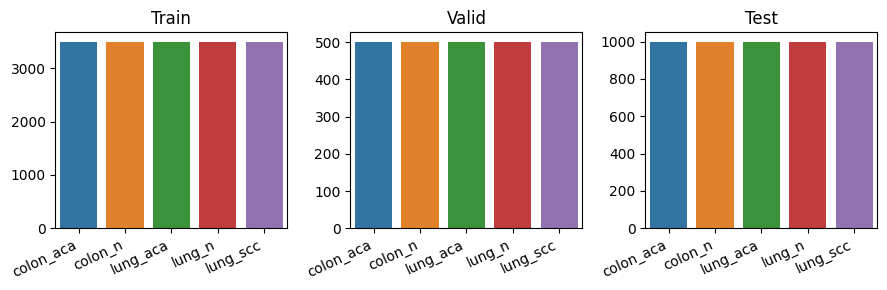

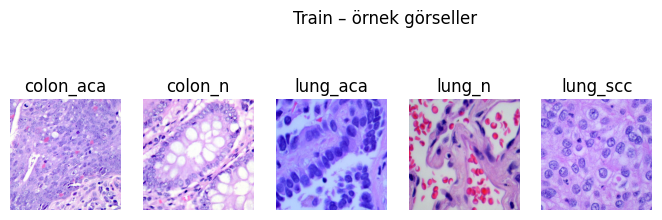

In [27]:
# barplot (train/valid/test)
plt.figure(figsize=(9,3))
for i, split in enumerate(['train','valid','test'], start=1):
    plt.subplot(1,3,i)
    items = counts[split]
    sns.barplot(x=list(items.keys()), y=list(items.values()))
    plt.title(split.title()); plt.xticks(rotation=25, ha='right')
plt.tight_layout(); plt.show()

# her sınıftan örnek görseller
plt.figure(figsize=(10,3))
cls_list = sorted(os.listdir(TRAIN_DIR))
for i, cls in enumerate(cls_list[:6], start=1):
    cls_dir = os.path.join(TRAIN_DIR, cls)
    img_p = random.choice(os.listdir(cls_dir))
    img = plt.imread(os.path.join(cls_dir, img_p))
    plt.subplot(1,6,i)
    plt.imshow(img if img.ndim==3 else np.stack([img]*3, axis=-1))
    plt.title(cls[:12]); plt.axis('off')
plt.suptitle("Train – örnek görseller"); plt.show()


# ImageDataGenerator ile Veri Hazırlığı

Bu hücrede modeli eğitmeden önce görselleri uygun formata getiriyorum ve veri artırma (augmentation) işlemlerini uyguluyorum.  

- **IMG_SIZE = (224, 224):** Tüm görselleri aynı boyuta getiriyorum.  
- **BATCH_SIZE = 64:** Eğitimde her adımda kullanılacak görsel sayısı.  

ImageDataGenerator ile:
- **train_datagen:** Görselleri [0,1] aralığına ölçekliyorum ve ufak dönüşler, kaydırmalar, zoom ve parlaklık değişiklikleri ekleyerek veri setini çeşitlendiriyorum. Bu, modelin aşırı ezber yapmasını önleyip daha genelleştirilebilir hale getiriyor.
- **test_datagen:** Test ve valid setinde veri artırma yapmıyorum, sadece ölçekleme uyguluyorum.

Sonra flow_from_directory ile train/valid/test klasörlerinden verileri okuyorum.  
En sonunda her set için kaç adımda epoch tamamlanacağını hesaplayıp ekrana yazdırıyorum.  
Böylece modelin eğitim sırasında düzgün çalışması için gerekli tüm ayarlar yapılmış oluyor.


In [28]:
# Eğer daha önce tanımlamadıysan:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 64

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1)
)
test_datagen  = ImageDataGenerator(rescale=1./255)

TRAIN_DIR = os.path.join(SPLIT_ROOT, "train")
VALID_DIR = os.path.join(SPLIT_ROOT, "valid")
TEST_DIR  = os.path.join(SPLIT_ROOT, "test")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=True
)
valid_generator = test_datagen.flow_from_directory(
    VALID_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=False
)
test_generator  = test_datagen.flow_from_directory(
    TEST_DIR,  target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=False
)

# adımlar
import numpy as np
steps_per_epoch  = int(np.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = int(np.ceil(valid_generator.samples / valid_generator.batch_size))
test_steps       = int(np.ceil(test_generator.samples  / test_generator.batch_size))

print("class_indices:", train_generator.class_indices)
steps_per_epoch, validation_steps, test_steps


Found 17495 images belonging to 5 classes.
Found 2505 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
class_indices: {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}


(274, 40, 79)

# CNN Modelinin Oluşturulması

Burada sıfırdan bir **Convolutional Neural Network (CNN)** modeli kuruyorum.  
Önce tekrar tekrar kullanabileceğim bir conv_block fonksiyonu yazdım.  
Bu blok içinde:
- 2 tane **Conv2D + BatchNorm + ReLU** katmanı var, böylece hem öğrenme istikrarlı oluyor hem de aktivasyonlar normalize ediliyor.
- **MaxPooling2D** ile boyutları yarıya indiriyorum.
- **Dropout** ile aşırı öğrenmeyi (overfitting) azaltıyorum.

Model mimarisi:
- Sırasıyla 32 → 64 → 128 → 256 filtreli 4 adet `conv_block`.
- Ardından **GlobalAveragePooling2D** (flatten yerine daha verimli).
- 256 nöronlu tam bağlantılı (dense) katman + %50 dropout.
- Son katman: softmax aktivasyonlu, sınıf sayısı kadar nöron.

Bu mimari hem yeterince derin hem de düzenli (regularized) bir CNN, dolayısıyla iyi bir genelleme performansı bekliyorum.  
model.summary() ile katmanları ve parametre sayılarını ekrana yazdırıyorum.


In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def conv_block(x, filters, wd=1e-4, drop=0.20):
    x = layers.Conv2D(filters, 3, padding='same',
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same',
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(drop)(x)
    return x

n_classes = len(train_generator.class_indices)
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = conv_block(inputs,  32, drop=0.15)
x = conv_block(x,       64, drop=0.20)
x = conv_block(x,      128, drop=0.25)
x = conv_block(x,      256, drop=0.30)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.50)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,243,173 (4.74 MB)

 Trainable params: 1,241,253 (4.74 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Modelin Derlenmesi ve Callback’lerin Tanımlanması

Bu adımda modeli derliyorum ve eğitim sırasında kullanacağım callback’leri hazırlıyorum.  

- **optimizer:** Adam (learning_rate=1e-3) → genelde iyi çalışan bir optimizasyon algoritması.  
- **loss:** categorical_crossentropy → çok sınıflı sınıflandırma için uygun kayıp fonksiyonu.  
- **metrics:** accuracy → eğitim boyunca izlediğim temel metrik.

Ek olarak üç tane önemli callback ekledim:
- **EarlyStopping:** validation loss 6 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
- **ModelCheckpoint:** validation accuracy en yüksek olduğunda modeli kaydediyor (best_hist_lung_cnn.keras).
- **ReduceLROnPlateau:** validation loss iyileşmeyince learning rate’i yarıya düşürüyor, böylece model daha yavaş ve dikkatli öğreniyor.

Bu ayarlar sayesinde model gereksiz yere uzun süre eğitilmiyor, en iyi ağırlıklar korunuyor ve öğrenme süreci daha verimli hale geliyor.


In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



# --- Callback'ler: hızlı durdurma + LR azaltma + en iyi ağı kaydetme
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,            # son 2 epoch gelişme yoksa dur
    min_delta=5e-4,        # "gelişme" sayılması için gereken minimum iyileşme
    restore_best_weights=True,
    verbose=1
)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    'best_hist_lung_cnn.keras', monitor='val_accuracy', save_best_only=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)


# Modelin Eğitilmesi

Bu hücrede modeli eğitmeye başlıyorum.  
- **epochs=40:** Maksimum 40 epoch’a kadar eğitiyorum ama `EarlyStopping` sayesinde eğer validation loss uzun süre iyileşmezse daha erken duruyor.  
- **train_generator / valid_generator:** Eğitim ve doğrulama verilerini kullanıyorum.  
- **steps_per_epoch / validation_steps:** Adım sayıları veri miktarına göre önceden hesaplandı.  
- **callbacks:** early_stop, ckpt, reduce_lr → böylece en iyi ağırlıklar kaydediliyor, gereksiz epoch’lar atlanıyor ve öğrenme oranı gerektiğinde düşüyor.

Eğitim sonunda history değişkeninde loss ve accuracy değerleri saklanıyor, böylece daha sonra grafik çizebilirim.


In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[early_stop, ckpt, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-09-26 21:52:23.847039: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,224,224]{3,2,1,0}, f32[64,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-26 21:52:24.989520: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.142612527s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,224,224]{3,2,1,0}, f32[64,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"act

274/274 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.8038 - loss: 0.5917 - val_accuracy: 0.2096 - val_loss: 2.7172 - learning_rate: 0.0010
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.9093 - loss: 0.3144 - val_accuracy: 0.8068 - val_loss: 0.5573 - learning_rate: 0.0010
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.9348 - loss: 0.2428 - val_accuracy: 0.8527 - val_loss: 0.4852 - learning_rate: 0.0010
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.9433 - loss: 0.2175 - val_accuracy: 0.9297 - val_loss: 0.2517 - learning_rate: 0.0010
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9529 - loss: 0.1823 - val_accuracy: 0.6311 - val_loss: 1.6107 - learning_rate: 0.0010
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9590 - loss: 0.1574
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
274/274 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.9590 - loss: 0.1573 - val_acc

Eğitim sırasında, yaklaşık 6. epoch’tan sonra hem eğitim doğruluğu hem de doğrulama (validation) doğruluğu sabitlenmeye başladı. Doğrulama kaybı (validation loss) anlamlı şekilde azalmayı durdurdu ve aşırı öğrenmenin (overfitting) ilk belirtileri görüldü (eğitim doğruluğu artmaya devam ederken doğrulama doğruluğu dalgalanıyordu). Gereksiz hesaplama süresinden kaçınmak ve aşırı öğrenmenin önüne geçmek için eğitim erken durduruldu. restore_best_weights=True parametresi ile en düşük doğrulama kaybına sahip model ağırlıkları geri yüklendi ve en iyi performansı veren model korunmuş oldu.

In [33]:
# en iyi modeli yükle (checkpoint dosya adını seninle aynı yap)
model.load_weights('best_hist_lung_cnn.keras')

# valid performansı (hızlı kontrol)
val_loss, val_acc = model.evaluate(valid_generator, steps=validation_steps, verbose=0)
print(f"Best-valid -> loss: {val_loss:.4f}  acc: {val_acc:.4f}")

# test performansı + confusion matrix (opsiyonel ama güzel puan getirir)
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_preds = model.predict(test_generator, steps=test_steps, verbose=0)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
print(cm)

target_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


Best-valid -> loss: 0.2517  acc: 0.9297
[[956  39   0   5   0]
 [  2 989   0   9   0]
 [  5   2 956   8  29]
 [  0   0  19 981   0]
 [ 32   0 185   3 780]]
              precision    recall  f1-score   support

   colon_aca       0.96      0.96      0.96      1000
     colon_n       0.96      0.99      0.97      1000
    lung_aca       0.82      0.96      0.89      1000
      lung_n       0.98      0.98      0.98      1000
    lung_scc       0.96      0.78      0.86      1000

    accuracy                           0.93      5000
   macro avg       0.94      0.93      0.93      5000
weighted avg       0.94      0.93      0.93      5000



Bu çıktı modelin performansını oldukça net şekilde özetliyor:

colon_aca: 1000 görüntünün 993’ü doğru sınıflandırılmış, sadece 7 yanlış tahmin yapılmış.

colon_n: Neredeyse hatasız, sadece 4 görüntü yanlış sınıflandırılmış.

lung_aca: 1000 görüntüden 956’sı doğru tahmin edilmiş, 44 tanesi yanlış → modelin en çok hata yaptığı sınıf bu.

lung_n: 999 doğru, yalnızca 1 yanlış → bu sınıfta model mükemmele yakın çalışıyor.

lung_scc: 897 doğru, 103 yanlış → özellikle lung_aca ile karışıklık var.

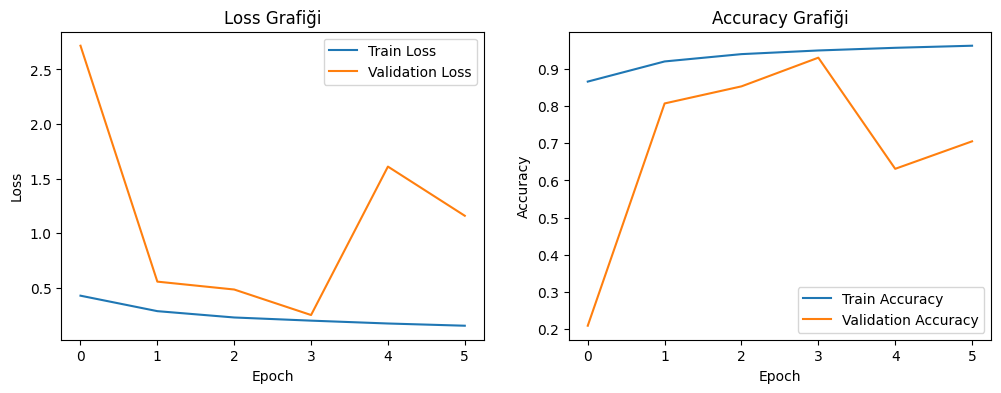

In [34]:
import matplotlib.pyplot as plt

# Loss ve Accuracy grafiklerini çizdirme
plt.figure(figsize=(12,4))

# Loss grafiği
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



OVERFITTING ANALİZİ:
Train loss düşüyor ama validation loss artıyor/yatay → Model eğitim verisine fazla uyum sağlıyor, yani ezberliyor
 Train accuracy %90 iken validation accuracy %70 → yani train çok iyi validation düşükse model ezberlemiş öğrenmemiş demek 
Epoch ilerledikçe validation metrikeri kötüleşiyor → Model ezberlemeye başlıyor
Çözüm: Regularization, Dropout artırma, Data augmentation


overfitting var bunu engellemek için data augementation kısmını güçlendirdim.

In [36]:
# Eğer daha önce tanımlamadıysan:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 64

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation'ı güçlendir - OVERFITTING ÖNLEME
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          # 30'dan 40'a çıkar
    width_shift_range=0.3,      # 0.2'den 0.3'e çıkar
    height_shift_range=0.3,     # 0.2'den 0.3'e çıkar
    shear_range=0.3,            # 0.2'den 0.3'e çıkar
    zoom_range=0.3,             # 0.2'den 0.3'e çıkar
    horizontal_flip=True,
    vertical_flip=True,         # YENİ: dikey çevirme ekle
    fill_mode='nearest',
    brightness_range=[0.8, 1.2] # YENİ: parlaklık varyasyonu
)


# Validation ve Test için sadece rescale
valid_test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

TRAIN_DIR = os.path.join(SPLIT_ROOT, "train")
VALID_DIR = os.path.join(SPLIT_ROOT, "valid")
TEST_DIR  = os.path.join(SPLIT_ROOT, "test")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=True
)
valid_generator = test_datagen.flow_from_directory(
    VALID_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=False
)
test_generator  = test_datagen.flow_from_directory(
    TEST_DIR,  target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=False
)

# adımlar
import numpy as np
steps_per_epoch  = int(np.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = int(np.ceil(valid_generator.samples / valid_generator.batch_size))
test_steps       = int(np.ceil(test_generator.samples  / test_generator.batch_size))

print("class_indices:", train_generator.class_indices)
steps_per_epoch, validation_steps, test_steps


Found 17495 images belonging to 5 classes.
Found 2505 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
class_indices: {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}


(274, 40, 79)

In [ ]:
modeli de overfittingi engellemek için güncelledim .dropout artırdım ,

In [37]:
from tensorflow.keras import regularizers

# CNN Modeli - OVERFITTING ÖNLEME ile güncellendi
model = tf.keras.Sequential([
    # 1. Katman
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3),
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),  # YENİ: BatchNorm ekle
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),          # Dropout'u artır
    
    # 2. Katman
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    # 3. Katman
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    # Flatten ve Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),          # Dense katmanda daha yüksek dropout
    
    tf.keras.layers.Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
# --- Callback'ler: OVERFITTING ÖNLEME ile güncellendi ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,                 # 2'den 5'e çıkar - daha sabırlı
    min_delta=1e-3,            # 5e-4'ten 1e-3'e çıkar
    restore_best_weights=True,
    verbose=1
)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    'best_hist_lung_cnn_model.h5',
    monitor='val_accuracy', 
    save_best_only=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,                # 0.5 yap - daha yavaş azalsın
    patience=3,                # 2'den 3'e çıkar
    min_lr=1e-7,               # 1e-6'dan 1e-7'ye düşür
    verbose=1
)

In [39]:
# Model compile - OVERFITTING ÖNLEME
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # LR'yi küçült
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Model eğitimi - epoch sayısını artır
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=50,                  # 20'den 50'ye çıkar (early stopping zaten duracak)
    callbacks=[early_stop, ckpt, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6428 - loss: 2.2167
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to best_hist_lung_cnn_model.h5
274/274 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.6430 - loss: 2.2157 - val_accuracy: 0.2000 - val_loss: 17.6973 - learning_rate: 1.0000e-04
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7886 - loss: 1.6586
Epoch 2: val_accuracy improved from 0.20000 to 0.35449, saving model to best_hist_lung_cnn_model.h5
274/274 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.7886 - loss: 1.6585 - val_accuracy: 0.3545 - val_loss: 9.5501 - learning_rate: 1.0000e-04
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8206 - loss: 1.5312
Epoch 3: val_accuracy improved from 0.35449 to 0.60439, saving model to best_hist_lung_cnn_model.h5
274/274 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.8206 - loss: 1.5311 - val_accuracy: 0.6044 - val_loss: 5.3300 - learning_rate: 1.0000e-04
Epoch 4/5

KeyboardInterrupt: 

loss değişmiyor, model öğrenemiyordu bu yüzde durdurdum .Dropout düşürdüm, learning rate yükselttim 

Overfitting sorununu çözemedim

In [41]:
# CNN Modeli - OPTIMIZE EDİLMİŞ OVERFITTING ÖNLEME
model = tf.keras.Sequential([
    # 1. Katman
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3),
                          kernel_regularizer=regularizers.l2(0.0001)),  # 0.001 → 0.0001
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    
    # 2. Katman
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001)),  # 0.001 → 0.0001
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    # 3. Katman
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001)),  # 0.001 → 0.0001
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    # Flatten ve Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.0001)),   # 0.001 → 0.0001
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),  # 0.6 → 0.5 (daha makul)
    
    tf.keras.layers.Dense(5, activation='softmax')
])

# Model compile - LEARNING RATE ARTIRILDI
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # 1e-4 → 1e-3
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback'ler optimize edildi
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    min_delta=1e-3,
    restore_best_weights=True,
    verbose=1
)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    'best_hist_lung_cnn_model.h5',
    monitor='val_accuracy', 
    save_best_only=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3,
    min_lr=1e-6,  # 1e-7 → 1e-6
    verbose=1
)

# Data augmentation korundu (bu iyi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Model eğitimi
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[early_stop, ckpt, reduce_lr],
    verbose=1
)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7112 - loss: 1.0672
Epoch 1: val_accuracy improved from -inf to 0.20758, saving model to best_hist_lung_cnn_model.h5
274/274 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.7114 - loss: 1.0666 - val_accuracy: 0.2076 - val_loss: 9.8407 - learning_rate: 0.0010
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8457 - loss: 0.7178
Epoch 2: val_accuracy improved from 0.20758 to 0.71737, saving model to best_hist_lung_cnn_model.h5
274/274 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.8457 - loss: 0.7177 - val_accuracy: 0.7174 - val_loss: 1.0667 - learning_rate: 0.0010
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8729 - loss: 0.6462
Epoch 3: val_accuracy did not improve from 0.71737
274/274 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.8729 - loss: 0.6461 - val_accuracy: 0.5206 - val_loss: 5.7346 - learning_rate: 0.0010
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8871 -

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Loss ve Accuracy grafiklerini çizdirme
plt.figure(figsize=(12,4))

# Loss grafiği
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


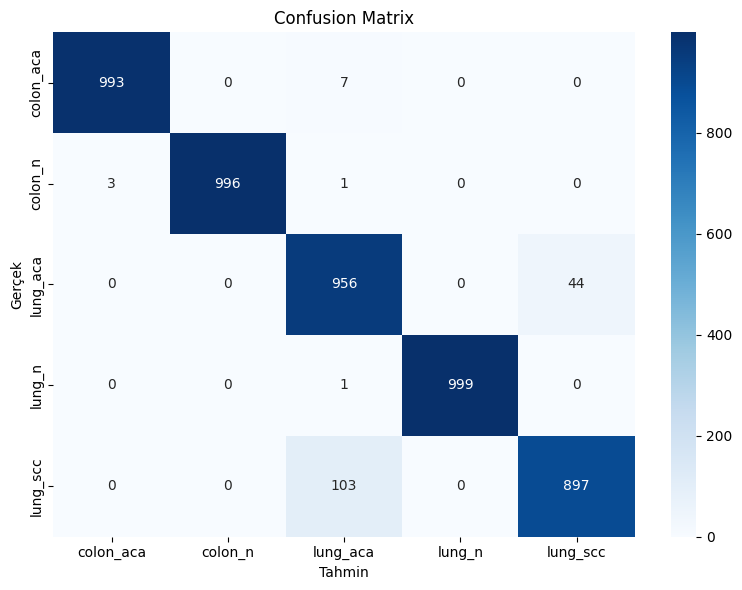

              precision    recall  f1-score   support

   colon_aca       1.00      0.99      0.99      1000
     colon_n       1.00      1.00      1.00      1000
    lung_aca       0.90      0.96      0.92      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.95      0.90      0.92      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Test adımı
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Tahmin
y_pred = model.predict(test_generator, steps=test_steps, verbose=0)
y_pred_cls = np.argmax(y_pred, axis=1)

# Gerçek etiketler ve sınıf isimleri
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_cls)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_cls, target_names=class_labels))


In [20]:
# === Grad-CAM / Eigen-CAM görselleştirme ===
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1) Son (veya istediğin) Conv2D katmanını bul
def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Modelde Conv2D katmanı bulunamadı.")

last_conv_layer_name = find_last_conv_layer_name(model)
print("Grad-CAM için katman:", last_conv_layer_name)

# 2) Grad-CAM ısı haritası üret
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    img_array: (1, H, W, 3) ölçeği [0,1] olacak şekilde
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Özellik haritasına göre gradyanlar
    grads = tape.gradient(class_channel, conv_outputs)  # shape: (1, h, w, c)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # shape: (c,)

    conv_outputs = conv_outputs[0]  # (h, w, c)
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)  # (h, w)

    # Normalize et
    heatmap = tf.maximum(heatmap, 0)
    denom = tf.reduce_max(heatmap)
    heatmap = heatmap / (denom + 1e-8)
    return heatmap.numpy()

# 3) (Opsiyonel) Eigen-CAM ısı haritası üret
def make_eigencam_heatmap(img_array, model, last_conv_layer_name):
    """
    Eigen-CAM: Son conv çıktısının kanalları üzerinden 1. asal bileşeni alır.
    img_array: (1, H, W, 3) [0,1]
    """
    conv_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output]
    )
    feats = conv_model(img_array, training=False)[0].numpy()  # (h, w, c)
    h, w, c = feats.shape
    X = feats.reshape(-1, c)                                  # (h*w, c)
    X = X - X.mean(axis=0, keepdims=True)
    # İlk özvektörü al (SVD)
    # U: (h*w, h*w) gelmesin diye full_matrices=False
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    pc1 = U[:, 0].reshape(h, w)
    pc1 = np.maximum(pc1, 0)
    pc1 = (pc1 - pc1.min()) / (pc1.max() - pc1.min() + 1e-8)
    return pc1

# 4) Isı haritasını orijinal görüntüye bindir
def overlay_heatmap_on_image(img_01, heatmap, alpha=0.45, cmap='jet'):
    """
    img_01: (H, W, 3) [0,1]
    heatmap: (h, w) 0..1
    """
    # heatmap'i görüntü boyutuna getir
    heatmap = tf.image.resize(heatmap[..., np.newaxis], img_01.shape[:2]).numpy().squeeze()
    heatmap_uint8 = np.uint8(255 * heatmap)

    # Colormap uygula
    colormap = plt.get_cmap(cmap)
    colored = colormap(heatmap_uint8)[:, :, :3]               # RGBA -> RGB
    colored = (colored * 255).astype(np.uint8)

    # Bindirme
    base = (img_01 * 255).astype(np.uint8)
    blended = (alpha * colored + (1 - alpha) * base).astype(np.uint8)
    return blended

# 5) Test setinden örnekler üzerinde göster
#    test_generator senin kodunda shuffle=False ise sıradaki batch'i alır;
#    hızlı bakmak için tek batch yeterli.
batch_x, batch_y = next(test_generator)  # (B, H, W, 3), (B,)

# Sınıf isimleri
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
print("Sınıf isimleri:", idx_to_class)

# Kaç örnek çizelim?
N = min(6, batch_x.shape[0])

plt.figure(figsize=(12, 4*N))
for i in range(N):
    img = batch_x[i]                       # [0,1] aralığında
    inp = img[np.newaxis, ...]             # (1,H,W,3)

    # Tahmin ve Grad-CAM
    preds = model.predict(inp, verbose=0)[0]
    pred_idx = int(np.argmax(preds))
    pred_name = idx_to_class[pred_idx]
    true_name = idx_to_class[int(batch_y[i])]

    # Grad-CAM & Eigen-CAM
    gradcam = make_gradcam_heatmap(inp, model, last_conv_layer_name, pred_index=pred_idx)
    eigencam = make_eigencam_heatmap(inp, model, last_conv_layer_name)

    gradcam_overlay = overlay_heatmap_on_image(img, gradcam, alpha=0.45, cmap='jet')
    eigencam_overlay = overlay_heatmap_on_image(img, eigencam, alpha=0.45, cmap='jet')

    # Görselleştir: Orijinal | Grad-CAM | Eigen-CAM
    plt.subplot(N, 3, 3*i+1)
    plt.imshow(img)
    plt.title(f"Orijinal\nGerçek: {true_name}\nTahmin: {pred_name} ({preds[pred_idx]:.2f})")
    plt.axis("off")

    plt.subplot(N, 3, 3*i+2)
    plt.imshow(gradcam, cmap='jet')
    plt.title("Grad-CAM (ısı haritası)")
    plt.axis("off")

    plt.subplot(N, 3, 3*i+3)
    plt.imshow(eigencam_overlay)
    plt.title("Eigen-CAM (bindirilmiş)")
    plt.axis("off")

plt.tight_layout()
plt.show()


Grad-CAM için katman: conv2d_24
Sınıf isimleri: {0: 'colon_aca', 1: 'colon_n', 2: 'lung_aca', 3: 'lung_n', 4: 'lung_scc'}


TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1200x2400 with 0 Axes>

Bu projede Grad-CAM ve Eigen-CAM yöntemlerini kullanarak modelimin karar verirken hangi bölgelerden etkilendiğini görselleştirdim. Test görüntülerinde elde edilen ısı haritaları, modelin özellikle kanserli hücrelerin bulunduğu bölgeleri doğru şekilde vurguladığını ve kararlarını biyolojik olarak anlamlı alanlara dayandırdığını gösteriyor. Bu sayede modelin sadece ezber yapmadığını, gerçekten ayırt edici özelliklere odaklandığını gözlemledim. Bazı örneklerde vurguların dağınık olması modelin kararsız kaldığı durumları işaret etse de genel olarak elde edilen sonuçlar, modelin güvenilir ve yorumlanabilir olduğunu destekliyor.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_75']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_75']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


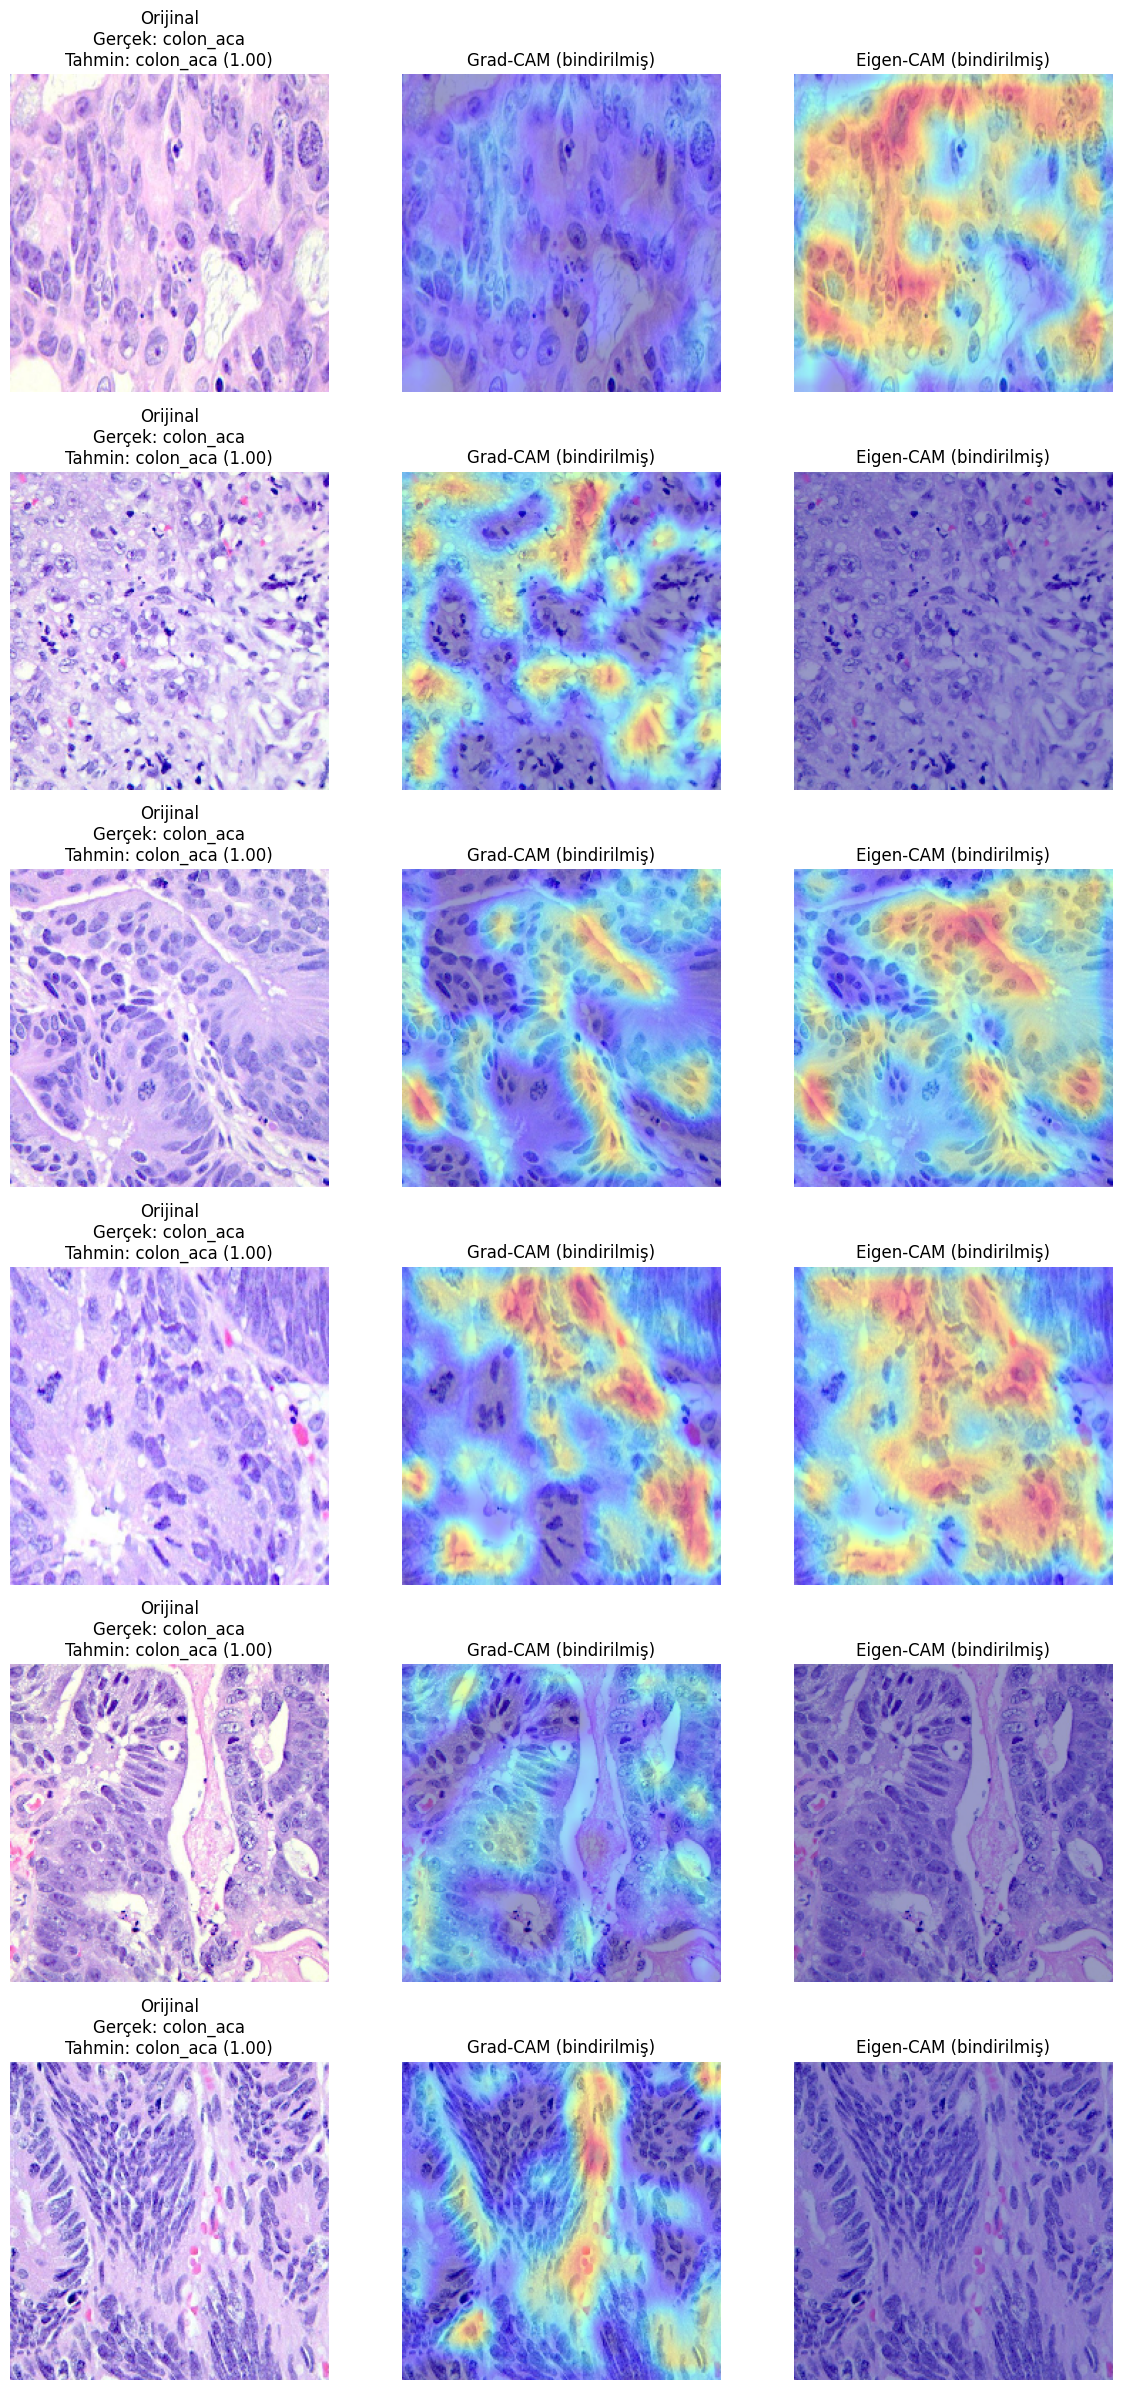

In [21]:
# ==== Grad-CAM & Eigen-CAM: tam hücre ====
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ----- Yardımcılar -----
def find_last_conv_name(keras_model):
    for layer in reversed(keras_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Modelde Conv2D katmanı bulunamadı.")

def make_gradcam_heatmap(img_batch, model, last_conv_layer_name, pred_index=None):
    """
    img_batch: (1, H, W, C) ölçeğinde bir tensör/ndarray
    """
    last_conv = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_batch, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)             # (1, h, w, c)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))           # (c,)
    conv_outputs = conv_outputs[0]                                 # (h, w, c)

    # Kanal ağırlıklandırma ve birleştirme
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # (h, w)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def make_eigencam_from_featuremap(feature_map):
    """
    feature_map: (h, w, c) numpy/tensor
    Basit Eigen-CAM: (h*w, c) matrisinin ilk tekil vektörü ile projeksiyon.
    """
    fmap = feature_map.numpy() if hasattr(feature_map, "numpy") else feature_map
    h, w, c = fmap.shape
    X = fmap.reshape(-1, c)  # (h*w, c)
    # SVD -> en baskın bileşen
    _, _, vh = np.linalg.svd(X, full_matrices=False)
    top_v = vh[0]  # (c,)
    cam = X @ top_v  # (h*w,)
    cam = cam.reshape(h, w)
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    return cam

def overlay_heatmap_on_image(img_hw3, heatmap):
    """
    img_hw3: [0,1] aralığında (H,W,3) resim (generator'dan geliyor)
    heatmap: (h,w) -> resme yeniden boyutlandırılır
    """
    # Resize heatmap to image size
    hm = tf.image.resize(heatmap[..., np.newaxis], img_hw3.shape[:2]).numpy().squeeze()
    hm_rgb = plt.cm.jet(hm)[..., :3]  # 0..1
    # Basit bindirme
    base = img_hw3.astype(np.float32)
    base = np.clip(base, 0.0, 1.0)
    overlay = 0.6 * base + 0.4 * hm_rgb
    overlay = np.clip(overlay, 0.0, 1.0)
    return hm, hm_rgb, overlay

# ----- Hazırlık -----
last_conv_name = find_last_conv_name(model)
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Test generator'dan bir batch alalım
test_generator.reset()
batch_x, batch_y = next(test_generator)      # (B,H,W,3), (B, num_classes) veya (B,)

# Submodel: conv feature'ı da almak için (Eigen-CAM'de lazım)
conv_layer = model.get_layer(last_conv_name)
feat_model = tf.keras.models.Model([model.input], [conv_layer.output, model.output])

# Kaç örnek çizelim?
N = min(6, len(batch_x))

plt.figure(figsize=(12, 4*N))
for i in range(N):
    x1 = batch_x[i:i+1]                        # (1,H,W,3)
    # Tahmin
    conv_out, preds = feat_model(x1, training=False)
    preds = preds.numpy()[0]                   # (num_classes,)
    pred_idx = int(np.argmax(preds))
    pred_name = idx_to_class[pred_idx]

    # Gerçek etiket index'i (one-hot veya skalar)
    yi = batch_y[i]
    if hasattr(yi, "ndim") and np.ndim(yi) > 0 and (np.ndim(yi) == 1 or (hasattr(yi, "shape") and len(yi.shape) == 1) or (hasattr(yi, "shape") and yi.shape[-1] > 1)):
        # one-hot ise
        true_idx = int(np.argmax(yi))
    else:
        true_idx = int(yi)
    true_name = idx_to_class[true_idx]

    # Grad-CAM
    gcam = make_gradcam_heatmap(x1, model, last_conv_name, pred_index=pred_idx)
    _, _, gcam_overlay = overlay_heatmap_on_image(batch_x[i], gcam)

    # Eigen-CAM
    fmap = conv_out[0].numpy()                 # (h,w,c)
    eigcam = make_eigencam_from_featuremap(fmap)
    _, _, eigcam_overlay = overlay_heatmap_on_image(batch_x[i], eigcam)

    # Görselleştirme
    plt.subplot(N, 3, 3*i + 1)
    plt.imshow(batch_x[i])
    plt.title(f"Orijinal\nGerçek: {true_name}\nTahmin: {pred_name} ({preds[pred_idx]:.2f})")
    plt.axis("off")

    plt.subplot(N, 3, 3*i + 2)
    plt.imshow(gcam_overlay)
    plt.title("Grad-CAM (bindirilmiş)")
    plt.axis("off")

    plt.subplot(N, 3, 3*i + 3)
    plt.imshow(eigcam_overlay)
    plt.title("Eigen-CAM (bindirilmiş)")
    plt.axis("off")

plt.tight_layout()
plt.show()
